In [21]:
# import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import os
from random import shuffle
import matplotlib.pyplot as plt 

In [ ]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [23]:
x_size = 230
y_size = 230
def load_features(name):
    decoded = name.decode("UTF-8")
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            features = np.array([file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]]).transpose(1,2,0)
            features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)

In [4]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [5]:
print(len(pkl_files))

2258


In [6]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [7]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [8]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [9]:
print(len(pkl_files_steel))

1722


In [10]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
shuffle(pkl_files)

In [11]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [12]:
print(len(pkl_files))

8077


In [13]:
dataset_len=len(pkl_files)

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((pkl_files))

def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.uint16, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

dataset = dataset.map(data_loader)
               # load_features, [filename], [tf.uint16, tf.string])))

In [28]:
dataset.shuffle(100)


train_size = np.floor(0.8 * dataset_len)
valid_size = np.floor(0.1 * dataset_len)
test_size = np.floor(0.1 * dataset_len)

train = dataset.take(train_size)
remaining = dataset.skip(train_size)
valid = remaining.take(valid_size)
test = remaining.skip(valid_size)

In [29]:
train = train.shuffle(100,  reshuffle_each_iteration=True)

In [79]:
norm_data = train.take(valid_size).map(lambda x, y: x) #

In [81]:
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(norm_data)

ValueError: in user code:

    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 117, in adapt_step  *
        self._adapt_maybe_build(data)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 274, in _adapt_maybe_build  **
        data_shape_nones = tuple([None] * len(data.shape))

    ValueError: Cannot take the length of shape with unknown rank.


In [133]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),
    # layers.RandomCrop(120,120, seed=in_seed, input_shape=(x_size,y_size,4)),
    layers.CenterCrop(120,120, ),
    # layers.Rescaling(1./10000),#,input_shape=(240,240,4)),
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed),
    norm_layer])

In [120]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [121]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(1, 230, 230, 4)
(3,)


In [122]:
train

<ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint16, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [123]:
model = tf.keras.Sequential([
    resize_rescale_augment,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [124]:
model.build()

In [125]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 120, 120, 4)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 16)      592       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 64)      

In [126]:
# image_batch, labels_batch = next(iter(dataset))

In [127]:
# validation_inputs, validation_targets = next(iter(valid))

In [128]:
# next(iter(valid))

In [133]:
epochs=20
batch_size = 40
history = model.fit(
  train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
  validation_data=valid.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
    validation_steps=1,
  epochs=epochs,
)

Epoch 1/20
146/146 [==============================] - 94s 630ms/step - loss: 0.8237 - binary_accuracy: 0.7534 - val_loss: 0.8219 - val_binary_accuracy: 0.7583
Epoch 2/20
146/146 [==============================] - 95s 651ms/step - loss: 0.6638 - binary_accuracy: 0.8165 - val_loss: 0.8455 - val_binary_accuracy: 0.7583
Epoch 3/20
146/146 [==============================] - 98s 669ms/step - loss: 0.6346 - binary_accuracy: 0.8235 - val_loss: 0.8744 - val_binary_accuracy: 0.7500
Epoch 4/20
146/146 [==============================] - 96s 657ms/step - loss: 0.6195 - binary_accuracy: 0.8297 - val_loss: 0.8758 - val_binary_accuracy: 0.7583
Epoch 5/20
146/146 [==============================] - 103s 705ms/step - loss: 0.6079 - binary_accuracy: 0.8340 - val_loss: 0.8215 - val_binary_accuracy: 0.7667
Epoch 6/20
146/146 [==============================] - 97s 662ms/step - loss: 0.5936 - binary_accuracy: 0.8389 - val_loss: 0.8307 - val_binary_accuracy: 0.7667
Epoch 7/20
146/146 [=========================

In [135]:
history.history

{'loss': [0.8236790299415588,
  0.6638243198394775,
  0.6345580220222473,
  0.6195027232170105,
  0.6078817844390869,
  0.5935801267623901,
  0.5932939052581787,
  0.5859193801879883,
  0.5768601298332214,
  0.5781650543212891,
  0.5697368383407593,
  0.5770413875579834,
  0.5717342495918274,
  0.5622901916503906,
  0.5620269775390625,
  0.563075840473175,
  0.5577449202537537,
  0.552181601524353,
  0.5498566627502441,
  0.5463148355484009],
 'binary_accuracy': [0.7534244656562805,
  0.8164952397346497,
  0.8235159516334534,
  0.829680323600769,
  0.8340182304382324,
  0.8388698697090149,
  0.8343607187271118,
  0.8325344324111938,
  0.8425797820091248,
  0.8397263884544373,
  0.8429225087165833,
  0.838127851486206,
  0.8386415243148804,
  0.8396691679954529,
  0.838127851486206,
  0.83869868516922,
  0.8446916937828064,
  0.8452625274658203,
  0.8482875227928162,
  0.8481733202934265],
 'val_loss': [0.8218598365783691,
  0.845478892326355,
  0.8744365572929382,
  0.8758195638656616,

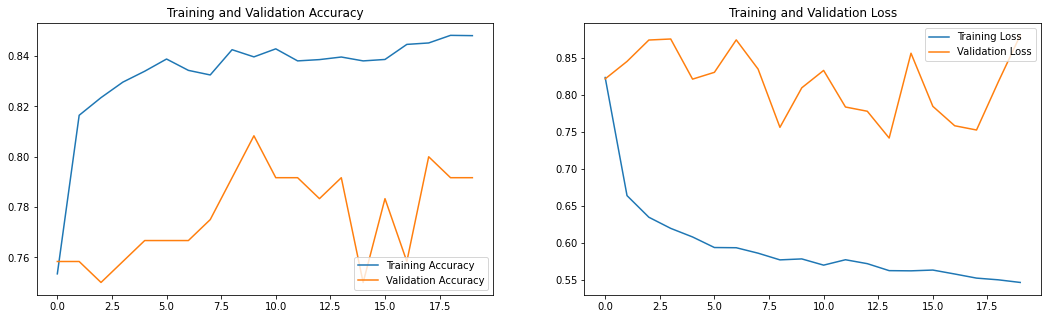

In [136]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [129]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)
next_element = iterator.get_next()
resize_and_rescale(next_element[0])

NameError: name 'resize_and_rescale' is not defined

In [130]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


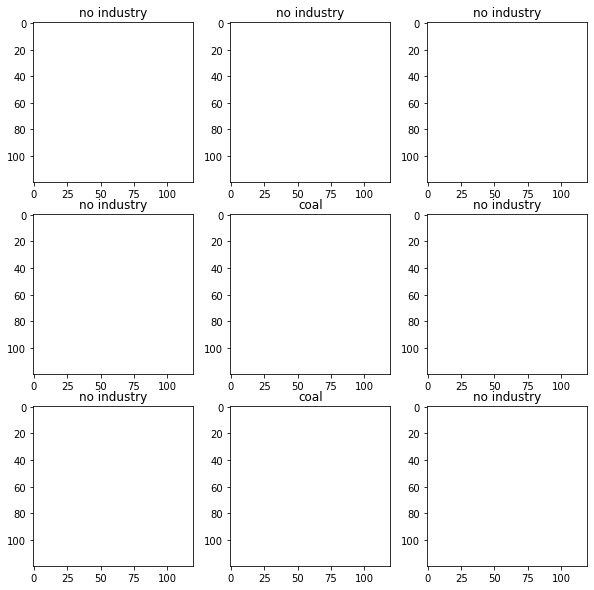

In [42]:
def convert_onehot(next_element):
    if (next_element[1].numpy() == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element[1].numpy() == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element[1].numpy() == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3], axis=2))
    plt.title(convert_onehot(next_element))

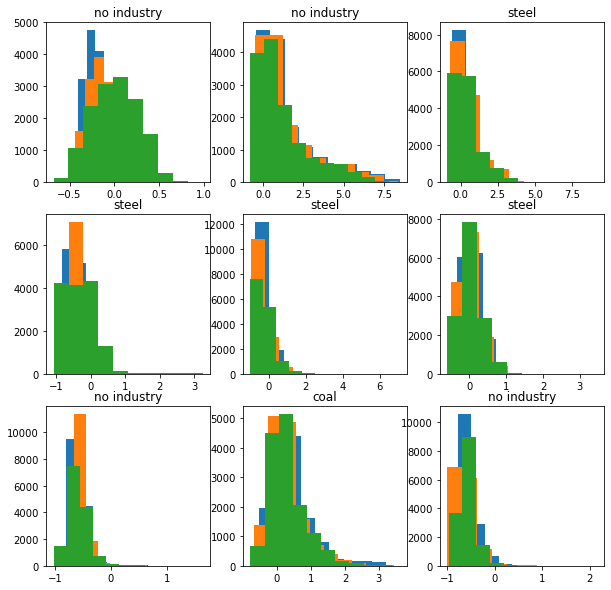

In [134]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.hist(im[0,:,:,0].numpy().reshape(120*120))
    plt.hist(im[0,:,:,1].numpy().reshape(120*120))
    plt.hist(im[0,:,:,2].numpy().reshape(120*120))
    plt.title(convert_onehot(next_element))

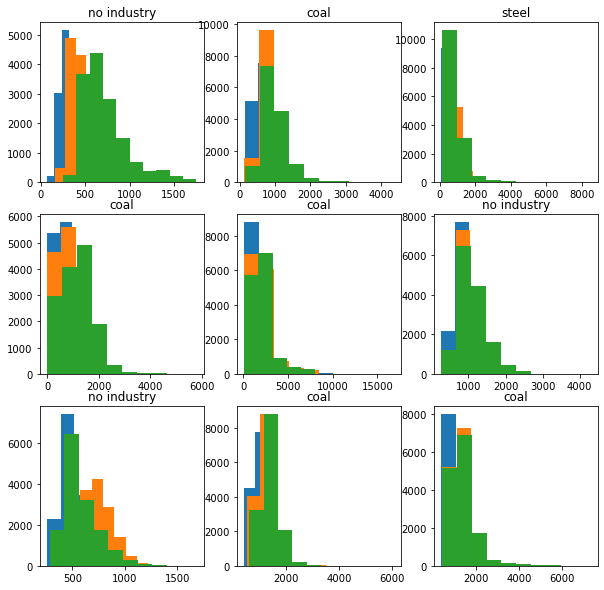

In [85]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.hist(im[0,:,:,0].numpy().reshape(120*120))
    plt.hist(im[0,:,:,1].numpy().reshape(120*120))
    plt.hist(im[0,:,:,2].numpy().reshape(120*120))
    plt.title(convert_onehot(next_element))

In [138]:
plt.figure(figsize=(10, 10))
ch1, ch2, ch3, ch4 = np.array([]),np.array([]),np.array([]),np.array([]),
for i in range(100):
    if i%10==0:print(i, '%')
    # ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    ch1 = np.append(ch1, im[0,:,:,0].numpy().reshape(120*120))
    ch2 = np.append(ch2, im[0,:,:,1].numpy().reshape(120*120))
    ch3 = np.append(ch3, im[0,:,:,2].numpy().reshape(120*120))
    ch4 = np.append(ch4, im[0,:,:,3].numpy().reshape(120*120))
    # plt.title(convert_onehot(next_element))

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


<Figure size 720x720 with 0 Axes>

In [139]:
ch1_mean, ch1_std = ch1.mean(), ch1.std()
ch2_mean, ch2_std = ch2.mean(), ch2.std()
ch3_mean, ch3_std = ch3.mean(), ch3.std()
ch4_mean, ch4_std = ch4.mean(), ch4.std()

In [140]:
print(ch1_mean, ch1_std)
print(ch2_mean, ch2_std)
print(ch3_mean, ch3_std)
print(ch4_mean, ch4_std)

0.12674507260502352 1.1316588815212536
0.11651696495000494 1.1315029079084442
0.11968482320224397 1.1044553168282727
0.06081561688049889 1.0411610830048117


In [141]:
ch1_mean, ch1_std = 970.4162903392252, 1051.8454702994397
ch2_mean, ch2_std = 1176.249944943864, 1031.262597521539
ch3_mean, ch3_std = 1273.2376818390699, 1117.068939085472
ch4_mean, ch4_std = 2266.9050137827385, 1241.5509461215606

In [142]:
norm_layer=keras.layers.Normalization(mean=[ch1_mean, ch2_mean, ch3_mean,ch4_mean], variance=[ch1_std**2, ch2_std**2, ch3_std**2, ch4_std**2])